## Image Classification of Album Cover Images

In [1]:
import numpy as np
import pandas as pd

import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchmetrics.classification import BinaryF1Score
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import os

!pip install -q torch-lr-finder
from torch_lr_finder import LRFinder

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Dataloaders and Datasets

In [2]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomPosterize(4, p = 0.25),
    transforms.ColorJitter(brightness = (0.15, 0.90)),
    transforms.RandomRotation(degrees = 15),
    transforms.ToTensor()
])

In [3]:
TRAIN_MERGED_PATH = "/kaggle/input/mumu-image-classification-album/mumu-images-classification/train"
TEST_MERGED_PATH = "/kaggle/input/mumu-image-classification-album/mumu-images-classification/test"

In [4]:
train_dataset = datasets.ImageFolder(TRAIN_MERGED_PATH, transform = transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)

test_dataset = datasets.ImageFolder(TEST_MERGED_PATH, transform = transforms.ToTensor())
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = True)

In [5]:
train_dataset[0][0].shape

torch.Size([3, 256, 256])

In [6]:
train_dataset.classes

['ai', 'human']

## Model

In [7]:
models.list_models(module=models)

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'googlenet',
 'inception_v3',
 'maxvit_t',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'regnet_x_16gf',
 'regnet_x_1_6gf',
 'regnet_x_32gf',
 'regnet_x_3_2gf',
 'regnet_x_400mf',
 'regnet_x_800mf',
 'regnet_x_8gf',
 'regnet_y_128gf',
 'regnet_y_16gf',
 'regnet_y_1_6gf',
 'regnet_y_32gf',
 'regnet_y_3_2gf',
 'regnet_y_400mf',
 'regnet_y_800mf',
 'regnet_y_8gf',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext101_64x4d',
 'resnext50_32x4d',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'sh

In [8]:
class CreativeNet(nn.Module):
    def __init__(self, train_baseline_classifier = False, num_output_classes = 2, dropout_rate = 0.20):
        super().__init__()
        
        # Set instance variables
        self.train_baseline_classifier = train_baseline_classifier
        self.num_outuput_classes = num_output_classes
        self.dropout_rate = dropout_rate
        
        # Set the current device for tensor calculations
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Baseline: MNASNet v1.3
        self.baseline = models.mnasnet1_3(weights = models.MNASNet1_3_Weights.IMAGENET1K_V1)
        
        # Freeze the parameters of the base model (including but not limited to the last layers)
        for param in self.baseline.parameters():
            param.requires_grad = False
        
        if self.train_baseline_classifier:
            for param in self.baseline.classifier.parameters():
                param.requires_grad = True
                
        # Fully-connected block
        self.fc1 = nn.Linear(1000, 128)
        self.dropout1 = nn.Dropout(self.dropout_rate)
        self.fc2 = nn.Linear(128, 32)
        self.dropout2 = nn.Dropout(self.dropout_rate)
        self.fc3 = nn.Linear(32, self.num_outuput_classes)
        
    def forward(self, x):
        # Baseline
        x = x.to(self.device)
        x = self.baseline(x)
        
        # FC Block
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.leaky_relu(self.fc3(x))
        x = torch.sigmoid(x)
        return x

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

MODEL_ARGS = {
    "train_baseline_classifier" : False, 
    "num_output_classes" : len(train_dataset.classes),
    "dropout_rate" : 0.35
}

model = CreativeNet(**MODEL_ARGS).to(device)

Using device cuda


Downloading: "https://download.pytorch.org/models/mnasnet1_3-a4c69d6f.pth" to /root/.cache/torch/hub/checkpoints/mnasnet1_3-a4c69d6f.pth
100%|██████████| 24.2M/24.2M [00:01<00:00, 20.5MB/s]


## Criterion and Optimiser

In [10]:
criterion = nn.CrossEntropyLoss()

  0%|          | 0/300 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 9.12E-02


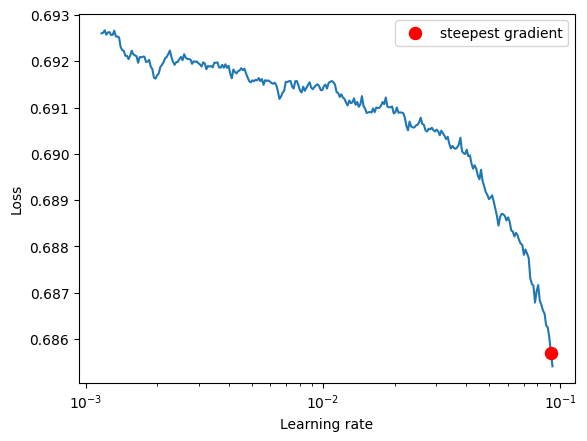

In [11]:
optimiser = optim.SGD(model.parameters(), lr = 0.001)
lr_finder = LRFinder(model, optimiser, criterion, device="cuda")
lr_finder.range_test(train_dataloader, end_lr=0.1, num_iter=300)

lr_finder.plot()
lr_finder.reset()

In [12]:
optimiser = optim.SGD(model.parameters(), lr = 9.12E-02)

## Metrics

In [13]:
metric = BinaryF1Score().to(device)

## Train and test the model

In [14]:
def train_test_loop(model, train_dataloader, test_dataloader, num_epochs = 100, save_prefix = "mumu_", verbose = False):
    # Save F1 scores and best model
    all_train_f1_scores = []
    all_test_f1_scores = []
    best_model = None
    candidate_f1_score = 0.0
    save_path = "fallback.pt"
    
    for epoch in tqdm(range(num_epochs)):
        # Training loop
        f1_scores = []
        model.train()
        for i, data in enumerate(train_dataloader, 0):
            # Load the inputs
            inputs, labels = data
            inputs = torch.Tensor(inputs).to(device)
            labels = torch.Tensor(labels).to(device)
                        
            # Forward + Backward + Optimise
            optimiser.zero_grad()
            outputs = model(inputs)
            outputs = torch.Tensor(outputs).to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimiser.step()
            
            # Training metrics calculation
            output_classes = torch.argmax(outputs, dim = 1)
            output_classes = torch.Tensor(output_classes).to(device)
            f1_score = metric(output_classes, labels)
            f1_scores.append(f1_score)
            
        # Update best scores and best model
        average_f1_score = (sum(f1_scores)/len(f1_scores))
        all_train_f1_scores.append(average_f1_score)
        if average_f1_score > candidate_f1_score:
            candidate_f1_score = average_f1_score
            average_f1_score_print = float(average_f1_score.cpu().detach())
            save_path = f"{save_prefix}_train_{str(average_f1_score_print).replace('.','_')}.pt"
            
        # Testing loop
        test_f1_scores = []
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(test_dataloader, 0):
                # Load the inputs
                inputs, labels = data
                inputs = torch.Tensor(inputs).to(device)
                labels = torch.Tensor(labels).to(device)

                # Forward
                outputs = model(inputs)
                outputs = torch.Tensor(outputs).to(device)
                output_classes = torch.argmax(outputs, dim = 1)
                output_classes = torch.Tensor(output_classes).to(device)
                
                # Testing metrics calculation
                f1_score = metric(output_classes, labels)
                test_f1_scores.append(f1_score)
            average_test_f1_score = (sum(test_f1_scores)/len(test_f1_scores))
            all_test_f1_scores.append(average_test_f1_score)
            
        
        # Verbose output if warranted
        if verbose:
            current_train_f1_score = all_train_f1_scores[-1]
            current_test_f1_score = all_test_f1_scores[-1]
            print(f"Train F1: {current_train_f1_score}, Test F1: {current_test_f1_score}")
        
    # Save best model at the end of the training loop
    torch.save(model.state_dict(), save_path)

In [15]:
TRAIN_ARGS = {
    "model" : model,
    "train_dataloader" : train_dataloader,
    "test_dataloader" : test_dataloader,
    "num_epochs" : 50,
    "save_prefix" : "mumu_mnas_1_3",
    "verbose" : True
}

In [16]:
train_test_loop(**TRAIN_ARGS)

  2%|▏         | 1/50 [00:03<02:40,  3.28s/it]

Train F1: 0.6686505079269409, Test F1: 0.6708130836486816


  4%|▍         | 2/50 [00:06<02:32,  3.18s/it]

Train F1: 0.6633700132369995, Test F1: 0.6651992797851562


  6%|▌         | 3/50 [00:09<02:29,  3.17s/it]

Train F1: 0.6736436486244202, Test F1: 0.6750883460044861


  8%|▊         | 4/50 [00:12<02:24,  3.14s/it]

Train F1: 0.6676605939865112, Test F1: 0.6655027866363525


 10%|█         | 5/50 [00:15<02:19,  3.11s/it]

Train F1: 0.6746289134025574, Test F1: 0.65216064453125


 12%|█▏        | 6/50 [00:18<02:15,  3.09s/it]

Train F1: 0.6732643842697144, Test F1: 0.6620908379554749


 14%|█▍        | 7/50 [00:21<02:13,  3.10s/it]

Train F1: 0.6755610704421997, Test F1: 0.6651244163513184


 16%|█▌        | 8/50 [00:24<02:10,  3.11s/it]

Train F1: 0.6756978034973145, Test F1: 0.6735107898712158


 18%|█▊        | 9/50 [00:28<02:07,  3.10s/it]

Train F1: 0.6728177070617676, Test F1: 0.6616424918174744


 20%|██        | 10/50 [00:31<02:05,  3.14s/it]

Train F1: 0.6874836683273315, Test F1: 0.6540939211845398


 22%|██▏       | 11/50 [00:34<02:05,  3.21s/it]

Train F1: 0.6802958250045776, Test F1: 0.6735161542892456


 24%|██▍       | 12/50 [00:37<02:00,  3.17s/it]

Train F1: 0.6936467289924622, Test F1: 0.6692825555801392


 26%|██▌       | 13/50 [00:40<01:56,  3.15s/it]

Train F1: 0.688995361328125, Test F1: 0.6668787002563477


 28%|██▊       | 14/50 [00:43<01:53,  3.14s/it]

Train F1: 0.7113714218139648, Test F1: 0.6496968269348145


 30%|███       | 15/50 [00:47<01:49,  3.13s/it]

Train F1: 0.7126703262329102, Test F1: 0.6865696907043457


 32%|███▏      | 16/50 [00:50<01:45,  3.11s/it]

Train F1: 0.7223614454269409, Test F1: 0.7030057907104492


 34%|███▍      | 17/50 [00:53<01:42,  3.11s/it]

Train F1: 0.7395679354667664, Test F1: 0.7138839960098267


 36%|███▌      | 18/50 [00:56<01:39,  3.09s/it]

Train F1: 0.7673900723457336, Test F1: 0.7238704562187195


 38%|███▊      | 19/50 [00:59<01:35,  3.08s/it]

Train F1: 0.7908921837806702, Test F1: 0.7123145461082458


 40%|████      | 20/50 [01:02<01:32,  3.09s/it]

Train F1: 0.7915375232696533, Test F1: 0.7489361763000488


 42%|████▏     | 21/50 [01:05<01:29,  3.08s/it]

Train F1: 0.8311498165130615, Test F1: 0.7546412348747253


 44%|████▍     | 22/50 [01:08<01:27,  3.13s/it]

Train F1: 0.8282706141471863, Test F1: 0.7592756152153015


 46%|████▌     | 23/50 [01:12<01:25,  3.16s/it]

Train F1: 0.8354725241661072, Test F1: 0.7851239442825317


 48%|████▊     | 24/50 [01:15<01:21,  3.14s/it]

Train F1: 0.839106023311615, Test F1: 0.7985860109329224


 50%|█████     | 25/50 [01:18<01:17,  3.11s/it]

Train F1: 0.8559554815292358, Test F1: 0.824015736579895


 52%|█████▏    | 26/50 [01:21<01:15,  3.13s/it]

Train F1: 0.848289966583252, Test F1: 0.8176314234733582


 54%|█████▍    | 27/50 [01:24<01:12,  3.13s/it]

Train F1: 0.8555644750595093, Test F1: 0.8132725954055786


 56%|█████▌    | 28/50 [01:27<01:09,  3.16s/it]

Train F1: 0.8694146871566772, Test F1: 0.8128936290740967


 58%|█████▊    | 29/50 [01:30<01:06,  3.18s/it]

Train F1: 0.8642744421958923, Test F1: 0.8030170798301697


 60%|██████    | 30/50 [01:34<01:03,  3.17s/it]

Train F1: 0.8680309057235718, Test F1: 0.8096417188644409


 62%|██████▏   | 31/50 [01:37<01:00,  3.20s/it]

Train F1: 0.886127769947052, Test F1: 0.8194565176963806


 64%|██████▍   | 32/50 [01:40<00:57,  3.19s/it]

Train F1: 0.8562977313995361, Test F1: 0.8229817152023315


 66%|██████▌   | 33/50 [01:43<00:54,  3.18s/it]

Train F1: 0.8690087795257568, Test F1: 0.8364540338516235


 68%|██████▊   | 34/50 [01:46<00:50,  3.15s/it]

Train F1: 0.8955607414245605, Test F1: 0.8277304172515869


 70%|███████   | 35/50 [01:49<00:46,  3.13s/it]

Train F1: 0.8702583312988281, Test F1: 0.8461580276489258


 72%|███████▏  | 36/50 [01:52<00:43,  3.10s/it]

Train F1: 0.8954861164093018, Test F1: 0.8338512182235718


 74%|███████▍  | 37/50 [01:55<00:40,  3.09s/it]

Train F1: 0.8868004083633423, Test F1: 0.8311513662338257


 76%|███████▌  | 38/50 [01:58<00:36,  3.07s/it]

Train F1: 0.908476710319519, Test F1: 0.8140206336975098


 78%|███████▊  | 39/50 [02:02<00:33,  3.08s/it]

Train F1: 0.8821044564247131, Test F1: 0.8403123617172241


 80%|████████  | 40/50 [02:05<00:30,  3.07s/it]

Train F1: 0.9149550199508667, Test F1: 0.8286557197570801


 82%|████████▏ | 41/50 [02:08<00:27,  3.09s/it]

Train F1: 0.8931757807731628, Test F1: 0.8425508737564087


 84%|████████▍ | 42/50 [02:11<00:24,  3.12s/it]

Train F1: 0.9164141416549683, Test F1: 0.8374084234237671


 86%|████████▌ | 43/50 [02:14<00:21,  3.11s/it]

Train F1: 0.9080654382705688, Test F1: 0.8450393080711365


 88%|████████▊ | 44/50 [02:17<00:18,  3.12s/it]

Train F1: 0.9027448892593384, Test F1: 0.84617680311203


 90%|█████████ | 45/50 [02:20<00:15,  3.13s/it]

Train F1: 0.8999776840209961, Test F1: 0.8467682600021362


 92%|█████████▏| 46/50 [02:23<00:12,  3.13s/it]

Train F1: 0.9102128744125366, Test F1: 0.851082980632782


 94%|█████████▍| 47/50 [02:27<00:09,  3.14s/it]

Train F1: 0.8980187177658081, Test F1: 0.8527764678001404


 96%|█████████▌| 48/50 [02:30<00:06,  3.20s/it]

Train F1: 0.9010821580886841, Test F1: 0.8465955257415771


 98%|█████████▊| 49/50 [02:33<00:03,  3.18s/it]

Train F1: 0.8965083956718445, Test F1: 0.8311233520507812


100%|██████████| 50/50 [02:36<00:00,  3.14s/it]

Train F1: 0.9056292772293091, Test F1: 0.8510743975639343
